In [20]:
# Imports & Parameters
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Parameters
START_DATE = '2020-01-01'
END_DATE = '2026-06-01'

# Top10 ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'TRX-USD', 'ADA-USD', 'DOGE-USD', 'ZEC-USD', 'LINK-USD']
# Top20 Generated ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'TRX-USD', 'MATIC-USD', 'LTC-USD', 'LINK-USD', 'BCH-USD', 'XLM-USD', 'ETC-USD', 'ATOM-USD', 'XMR-USD', 'VET-USD', 'ALGO-USD', 'FIL-USD', 'UNI-USD', 'EOS-USD']
# Top20 CMC as of January 2026 ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'SOL-USD', 'TRX-USD', 'DOT-USD', 'MATIC-USD', 'LTC-USD', 'LINK-USD', 'BCH-USD', 'XLM-USD', 'ETC-USD', 'ATOM-USD', 'XMR-USD', 'VET-USD', 'ALGO-USD', 'FIL-USD']
# Top4 old ['BTC-USD', 'ETH-USD', 'XRP-USD', 'ADA-USD']

TICKERS = ['BTC-USD']

In [21]:
# Download data for all tickers and add features
data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)

# Returns
returns = data['Close'].pct_change(fill_method=None)
returns.columns = pd.MultiIndex.from_product([['Returns'], returns.columns])

# Log Returns
log_returns = np.log(data['Close'] / data['Close'].shift(1))
log_returns.columns = pd.MultiIndex.from_product([['LogReturns'], log_returns.columns])

# Next day returns (shifted returns)
next_day_returns = returns.shift(-1)
next_day_returns.columns = pd.MultiIndex.from_product([['NextDayReturns'], TICKERS])

In [22]:
btc_returns = returns[('Returns', 'BTC-USD')]

# Calculate cumulative returns
cumulative_portfolio_returns = (1 + btc_returns).cumprod()

# Calculate performance metrics
total_return = (cumulative_portfolio_returns.iloc[-1] - 1) * 100
num_days = len(btc_returns)
num_years = num_days / 365  # Crypto markets open 365 days
annualized_return = (cumulative_portfolio_returns.iloc[-1] ** (365 / num_days) - 1) * 100
annualized_volatility = btc_returns.std() * np.sqrt(365) * 100
sharpe_ratio = (btc_returns.mean() / btc_returns.std()) * np.sqrt(365)

# Calculate maximum drawdown
cumulative = (1 + btc_returns).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min() * 100

# Display results
print("=" * 60)
print("BACKTEST RESULTS")
print("=" * 60)
print("Strategy: Equal-Weighted Crypto Portfolio")
print(" * Bounded Signal Strategy (long only)")
print(" * Signal based on volatility-normalized 20-day momentum")
print(f"Period: {btc_returns.index[0].strftime('%Y-%m')} to {btc_returns.index[-1].strftime('%Y-%m')}")
print(f"Number of years: {num_years:.2f}")
print("-" * 60)
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print("=" * 60)

BACKTEST RESULTS
Strategy: Equal-Weighted Crypto Portfolio
 * Bounded Signal Strategy (long only)
 * Signal based on volatility-normalized 20-day momentum
Period: 2020-01 to 2026-01
Number of years: 6.02
------------------------------------------------------------
Total Return: 1187.00%
Annualized Return: 52.88%
Annualized Volatility: 60.90%
Sharpe Ratio: 1.007
Maximum Drawdown: -76.63%


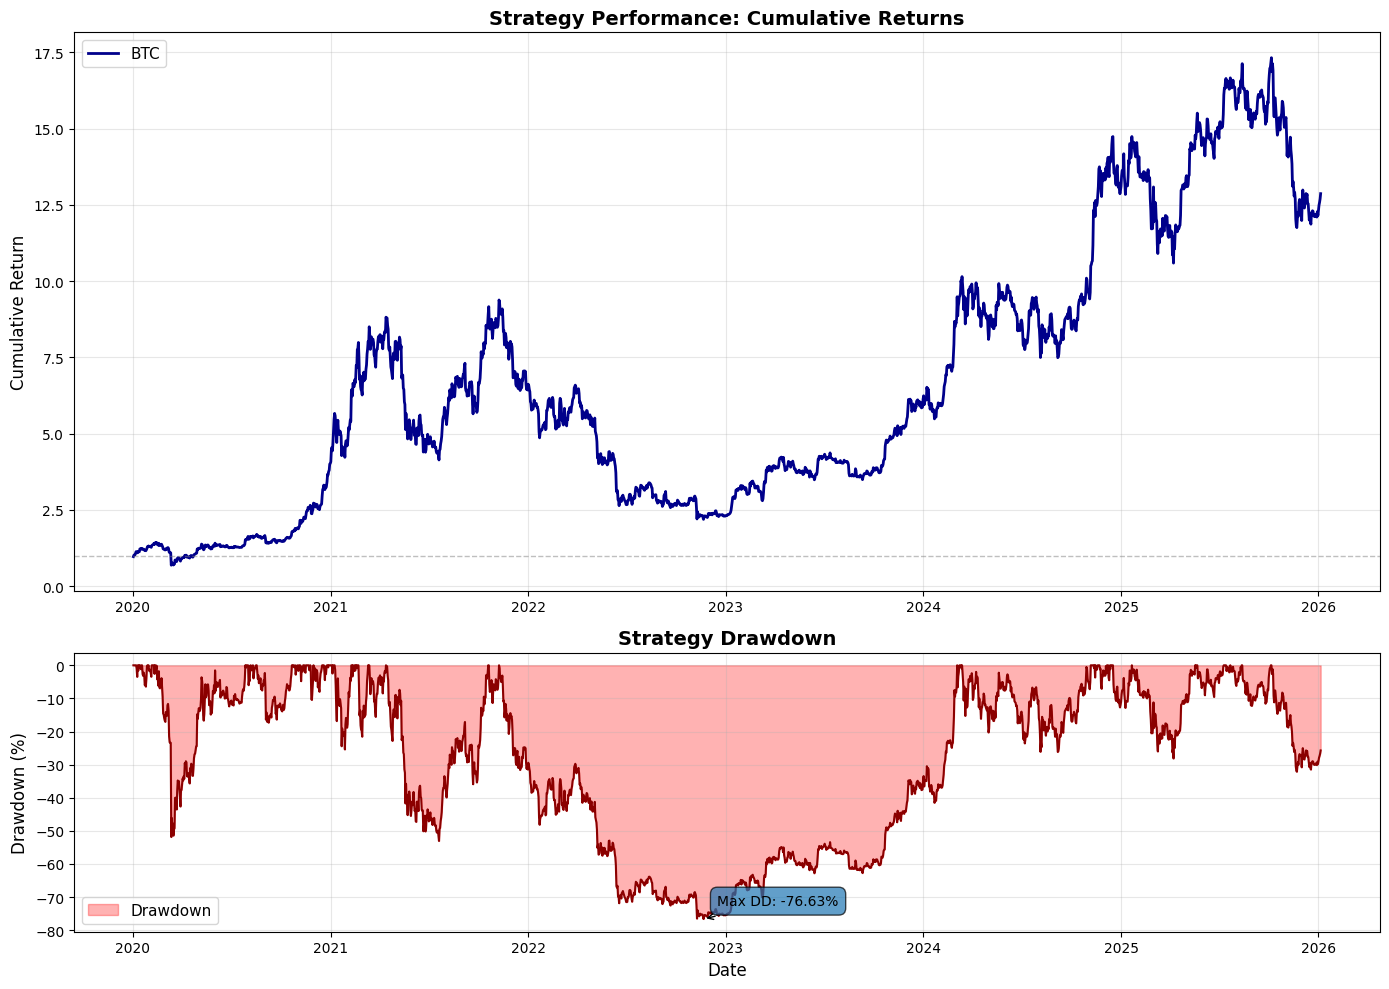

In [23]:
# Download BTC-USD benchmark data
btc_returns = returns[('Returns', 'BTC-USD')]
cumulative_btc = (1 + btc_returns).cumprod()

# Align BTC benchmark with portfolio returns for fair comparison
cumulative_btc_aligned = cumulative_btc.reindex(cumulative_portfolio_returns.index)

# Create strategy performance and drawdown plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Cumulative Returns (Equity Curve)
ax1.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, 
         linewidth=2, label='BTC', color='darkblue')

ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.set_title('Strategy Performance: Cumulative Returns', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Plot 2: Drawdown
ax2.fill_between(drawdown.index, drawdown * 100, 0, 
                 color='red', alpha=0.3, label='Drawdown')
ax2.plot(drawdown.index, drawdown * 100, 
         linewidth=1.5, color='darkred')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_title('Strategy Drawdown', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower left')
ax2.grid(True, alpha=0.3)

# Add annotation for max drawdown
max_dd_date = drawdown.idxmin()
ax2.annotate(f'Max DD: {max_drawdown:.2f}%', 
             xy=(max_dd_date, drawdown.min()*100),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

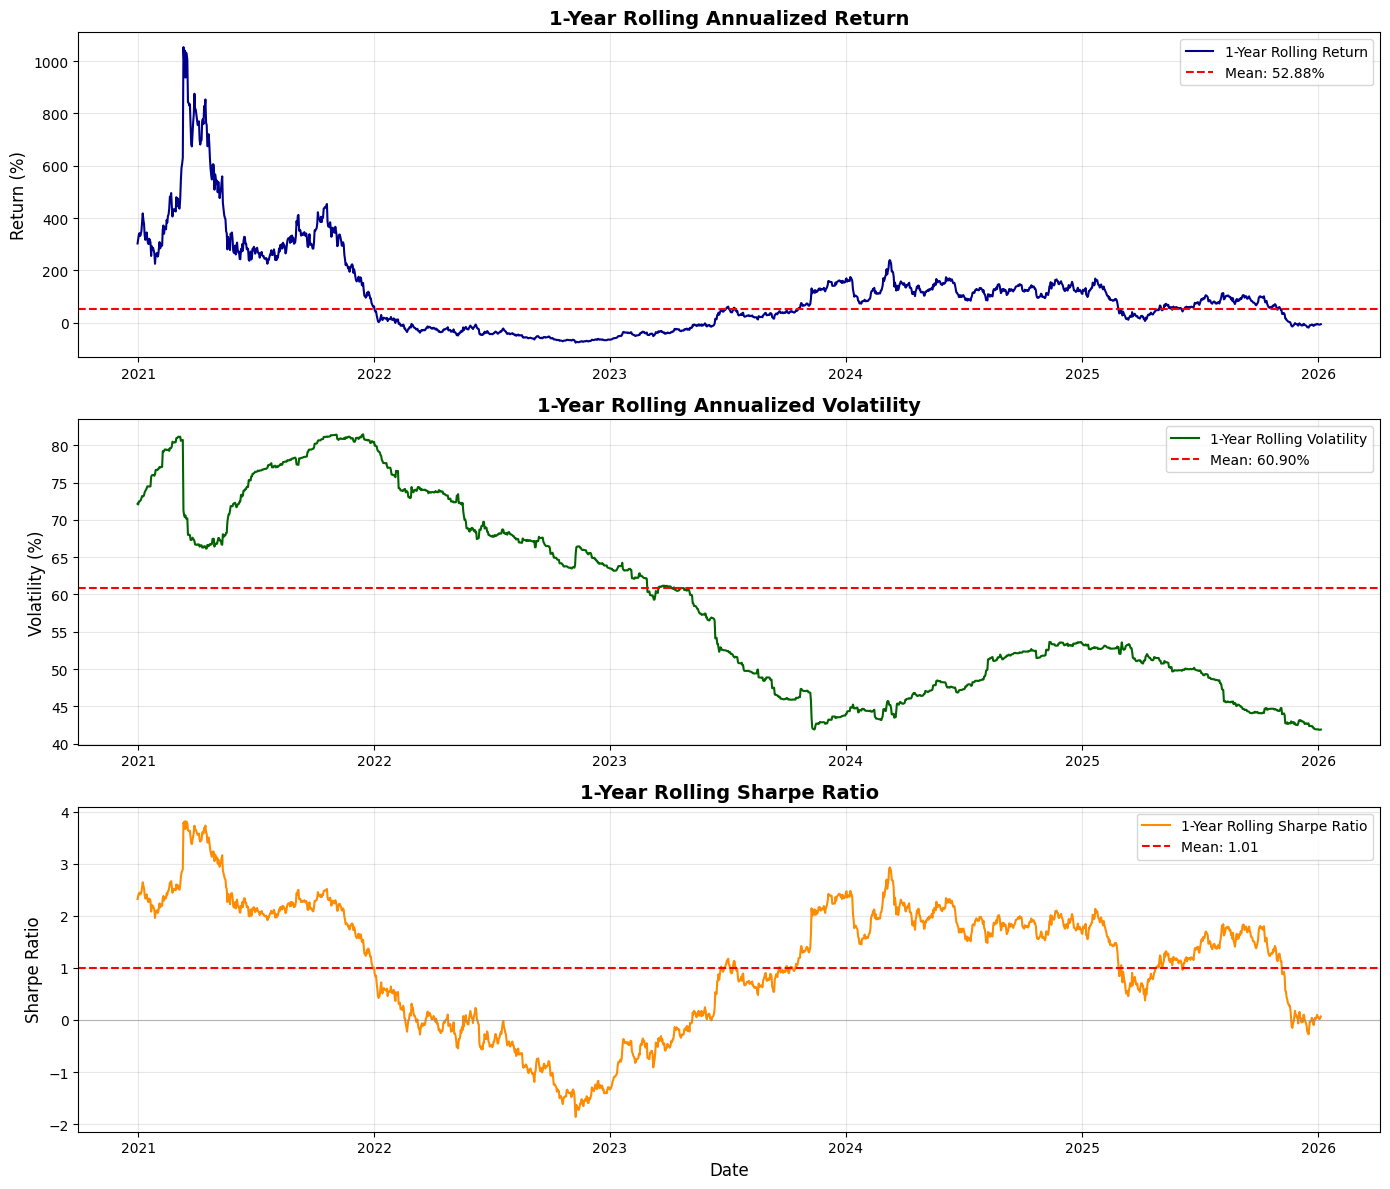

In [24]:
# Calculate 1-year rolling metrics for the strategy
rolling_window = 365  # 365 days = 1 year (crypto markets trade daily)

# 1-year rolling return (annualized)
rolling_return = btc_returns.rolling(window=rolling_window).apply(
    lambda x: (1 + x).prod() - 1
)

# 1-year rolling volatility (annualized)
rolling_vol = btc_returns.rolling(window=rolling_window).std() * np.sqrt(365)

# 1-year rolling Sharpe ratio
rolling_sharpe = (btc_returns.rolling(window=rolling_window).mean() / 
                  btc_returns.rolling(window=rolling_window).std()) * np.sqrt(365)

# Create the plots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Rolling Return
ax1 = axes[0]
ax1.plot(rolling_return.index, rolling_return * 100, 
         linewidth=1.5, color='darkblue', label='1-Year Rolling Return')
ax1.axhline(y=annualized_return, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {annualized_return:.2f}%')
ax1.set_ylabel('Return (%)', fontsize=12)
ax1.set_title('1-Year Rolling Annualized Return', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling Volatility
ax2 = axes[1]
ax2.plot(rolling_vol.index, rolling_vol * 100, 
         linewidth=1.5, color='darkgreen', label='1-Year Rolling Volatility')
ax2.axhline(y=annualized_volatility, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {annualized_volatility:.2f}%')
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.set_title('1-Year Rolling Annualized Volatility', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe Ratio
ax3 = axes[2]
ax3.plot(rolling_sharpe.index, rolling_sharpe, 
         linewidth=1.5, color='darkorange', label='1-Year Rolling Sharpe Ratio')
ax3.axhline(y=sharpe_ratio, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {sharpe_ratio:.2f}')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Sharpe Ratio', fontsize=12)
ax3.set_title('1-Year Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()